From the previous analysis we observed a excess of supply in central London when we averaged the data over a week. 

We want to understand how the flow of bikes changes at different times. It is not useful just to analyze the overall trips starting and ending at different times. Instead we can create a polygon specifying the excess supply area and analyze trips starting and ending in the different locations at different hours. 


# Creating Polygon

We use the polygon from the shapely library to create a geometric area representing central London. The polygon object is used for plotting on the map later and the polygon_geom is spatial co-ordinate data. 

In [149]:

import geopandas as gpd
from shapely.geometry import Polygon
from ipynb.fs.full.Visualize_Supply_and_Demand_Using_Maps import  mapClustersAndHeatMap
import pandas as pd
import os 
import folium
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def createPoly():
        lonList = [-0.18,-0.154,-0.148,-0.14,-0.13,-0.109,-0.105,-0.1,-0.09,-0.074,-0.074,-0.078,-0.117,-0.127,-0.14,-0.148,-0.162,-0.174,-0.18]
        latList = [51.5,51.518,51.52,51.521,51.523,51.522,51.524,51.523,51.527,51.524,51.509,51.5,51.497,51.493,51.493,51.492,51.489,51.494,51.495]
    
        polygon_geom = Polygon(zip(lonList, latList))
        
        polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])       
        return polygon,polygon_geom

# Plotting Polygon on Map

We can plot the polygon which captures the central supply area on the map we created in the previous section. First lets recreate the weekly map from the previous section. Then we can add the polygon we created above to the map. 



In [150]:

bikeStationsDemandWeekly = pd.read_pickle(os.path.join(os.getcwd(),r'pickles\bikeStationsDemandWeekly.pkl'))
mapWeekly = folium.Map(location = [51.5073219, -0.1276474], tiles='cartodbdark_matter' , zoom_start = 13)
mapWeekly = mapClustersAndHeatMap(mapWeekly,bikeStationsDemandWeekly)

polygon,poly_geom = createPoly()
fg_poly = folium.FeatureGroup(name = "Poly", show = True)
folium.GeoJson(polygon).add_to(fg_poly)
folium.LatLngPopup().add_to(fg_poly)
fg_poly.add_to(mapWeekly)
mapWeekly.add_child(folium.LayerControl())

mapWeekly

As can be seen the Polygon captures most of the supply within central London. You can change the feature settings to show demand at the top right corner. We see that most of the demand occurs outside of the polygon at the end of the week. We now have a geometric shape that captures the majority of the supply in central London. We can analyze bike flows into this shape over 24 hours to gain useful insights into the flow of bikes at different times.

# Temporal Analysis of Bike Flows in Polygon 

## Data Manipulation Logic
We want to understand the following

* How many bikes flow in and out of the Polygon at each hour 
* How does the demand change over time in the Polygon 

To do this we start by gathering the station data, trip data and polygaon data. We also convert the station data to a Geopandas DataFrame with the lat/lon of the station as the geometry. We also and set the index of the frame to the station id. 

In [151]:
bikeStations = pd.read_pickle(os.path.join(os.getcwd(),r'pickles\bikeStations.pkl'))
trips = pd.read_pickle(os.path.join(os.getcwd(),r'pickles\trips.pkl'))
bikeStations = gpd.GeoDataFrame(bikeStations,crs="EPSG:4326",geometry=gpd.points_from_xy(bikeStations.lon, bikeStations.lat) )
bikeStations.set_index('id',inplace = True)
bikeStations.index = bikeStations.index.astype(np.int64, copy=True)
bikeStations.head(5)


,$type,url,commonName,placeType,additionalProperties,children,childrenUrls,lat,lon,demand,geometry
id,,,,,,,,,,,
84,"Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...",/Place/BikePoints_84,"Breams Buildings, Holborn",BikePoint,[{'$type': 'Tfl.Api.Presentation.Entities.Addi...,[],[],51.515937,-0.111778,0,POINT (-0.11178 51.51594)
85,"Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...",/Place/BikePoints_85,"Tanner Street, Bermondsey",BikePoint,[{'$type': 'Tfl.Api.Presentation.Entities.Addi...,[],[],51.500647,-0.078600,0,POINT (-0.07860 51.50065)
86,"Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...",/Place/BikePoints_86,"Sancroft Street, Vauxhall",BikePoint,[{'$type': 'Tfl.Api.Presentation.Entities.Addi...,[],[],51.489479,-0.115156,0,POINT (-0.11516 51.48948)
87,"Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...",/Place/BikePoints_87,"Devonshire Square, Liverpool Street",BikePoint,[{'$type': 'Tfl.Api.Presentation.Entities.Addi...,[],[],51.516468,-0.079684,0,POINT (-0.07968 51.51647)
88,"Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...",/Place/BikePoints_88,"Bayley Street , Bloomsbury",BikePoint,[{'$type': 'Tfl.Api.Presentation.Entities.Addi...,[],[],51.518587,-0.132053,0,POINT (-0.13205 51.51859)


Next we filter the trip data so that it only contains id's that are valid indicies in our bikestation frame. 

In [152]:

trips  = trips[trips['StartStation Id'].isin(pd.Series(bikeStations.index))]
trips  = trips[trips['EndStation Id'].isin(pd.Series(bikeStations.index))]


We define three arrays to capture the number of trips starting in the polygon at time, ending at the polygon at time and the cumulative demand in the polygon at time. We also set the starting demand at hour 0 to be 0. 

In [153]:
tripsStartingInPoly = [] 
tripsEndingInPoly = []
demandInPolyAtTime = [] 
demandInPoly = 0

Next we apply a function similar to our previous analysis where we count the trips starting and iteratively over a 24 hour period. But now we also filter these counts based on which trips are starting and ending inside the polygon. We then capture this inside the previously defined arrays. 

In order to capture this data we check whether the id of the station which we have captured trips starting/ending in is inside the polygon we previously defined. 

In [154]:
for i in range(0,24):
    timeMaskEnd = (trips['End Date'].dt.hour >= i) & (trips['End Date'].dt.hour < i +1)
    timeMaskStart = (trips['Start Date'].dt.hour >= i) & (trips['Start Date'].dt.hour < i +1)

    ##Apply time masks and count the occurences of trips starting and ending in the hour for all trips 
    endFrame= trips[timeMaskEnd]
    endFrameCounts = endFrame['EndStation Id'].value_counts()
    startFrame = trips[timeMaskStart]
    startFrameCounts = startFrame['StartStation Id'].value_counts()

    #trips starting in polygon 
    startFrameCountsInPoly = startFrameCounts.copy().to_frame(name ="count").reset_index()
    m= startFrameCountsInPoly.apply( lambda x:poly_geom.contains(bikeStations.loc[x['index']].geometry),axis=1)
    startFrameCountsInPoly = startFrameCountsInPoly[m]

    #trips ending in polygon 
    endFrameCountsInPoly = endFrameCounts.copy().to_frame(name ="count").reset_index()
    m= endFrameCountsInPoly.apply( lambda x:poly_geom.contains(bikeStations.loc[x['index']].geometry),axis=1)
    endFrameCountsInPoly = endFrameCountsInPoly[m]
    
    #Capture polygon data in arrays
    #Demand in poly at time is cumalitvely calculated by adding the trips starting in the polygon 
    # and removing the trips ending in the polygon 
    tripsStartingInPoly.append( startFrameCountsInPoly['count'].sum())
    tripsEndingInPoly.append(endFrameCountsInPoly['count'].sum())
    demandInPoly =  demandInPoly + startFrameCountsInPoly['count'].sum() - endFrameCountsInPoly['count'].sum()
    demandInPolyAtTime.append(demandInPoly)



In [155]:
tripsStartingInPoly =np.array(tripsStartingInPoly)
tripsStartingInPoly

array([ 29461,  19446,  11912,   7999,   4937,   5960,  32973, 104840,
       205942, 130556,  92465, 111662, 150966, 161433, 164198, 184234,
       239710, 396606, 335559, 191009, 117717,  83222,  67602,  46356],
      dtype=int64)

In [156]:
tripsEndingInPoly =np.array(tripsEndingInPoly)
tripsEndingInPoly

array([ 20989,  15491,   9837,   7065,   6345,  11137,  54836, 178920,
       408853, 293973, 140781, 135231, 168550, 177728, 167567, 171234,
       199174, 280528, 259631, 153545,  93202,  61874,  47310,  34201],
      dtype=int64)

In [157]:
demandInPolyAtTime = np.array(demandInPolyAtTime)
demandInPolyAtTime

array([   8472,   12427,   14502,   15436,   14028,    8851,  -13012,
        -87092, -290003, -453420, -501736, -525305, -542889, -559184,
       -562553, -549553, -509017, -392939, -317011, -279547, -255032,
       -233684, -213392, -201237], dtype=int64)

Notice that we have 24 entries for each array. The two trip arrays correspond to the number of trips starting and ending inside the polygon at that hour. The demand array corresponds to the cumulative demand at that hour inside the polygon. 

## Graphs and Analysis 

We plot the data obtained in the previous section using Seaborn to understand the demand trends inside central London. 



<Figure size 432x288 with 0 Axes>

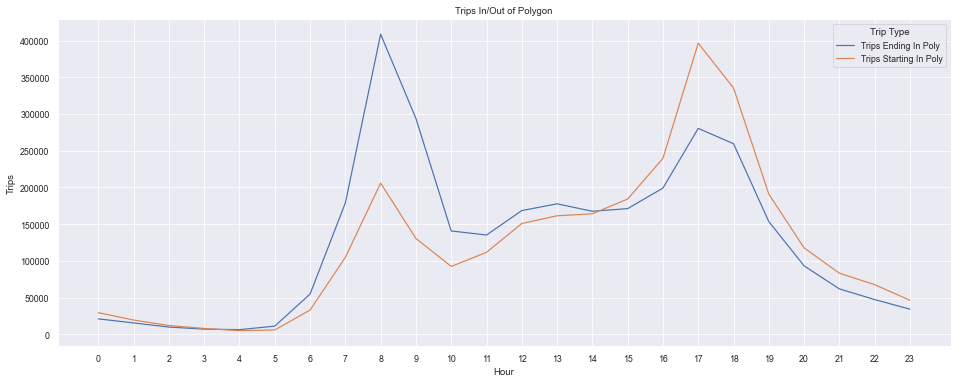

In [158]:
hours = [x for x in range(0,24)]
demandFrame = pd.DataFrame({"Hour":hours, "Demand":demandInPolyAtTime})
tripsFrame = pd.DataFrame({"Hour":hours, "Trips Ending In Poly":tripsEndingInPoly,"Trips Starting In Poly":tripsStartingInPoly})
tripsStartingInPoly = pd.DataFrame({"Hour":hours, "Trips Starting In Poly":tripsStartingInPoly})
tripsFrame = pd.melt(tripsFrame, ['Hour'])
tripsFrame.rename(columns = {'variable' : 'Trip Type', 'value' : 'Trips'}, inplace = True)
plt.clf()
sns.set_theme()
sns.set_context("paper")

plt.figure(figsize=(16, 6))

sns.lineplot(x='Hour', y='Trips', hue='Trip Type', data=tripsFrame).set(title="Trips In/Out of Polygon")

plt.xticks([i for i in range(0,24)])
plt.show()



We see a clear pattern in the data. Between 5am-8am and 5pm-7pm there is an overall larger number of trips ending and starting in the polygon. This corresponds to the rush hour traffic before work starts and ends. We also note that there are more trips into the polygon than out during the morning rush hour. There are more trips out of the polygon than into it during the evening rush hour. We can infer that the majority of the trips involve people entering central London during the morning and leaving it during the evening. We also plot the cumulative demand over time. 

<Figure size 432x288 with 0 Axes>

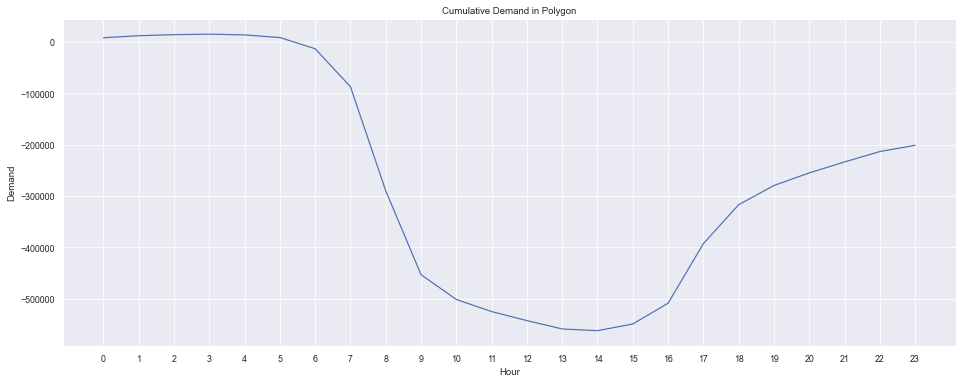

In [160]:

plt.clf()
plt.figure(figsize=(16, 6))
sns.lineplot(x="Hour",y="Demand",data = demandFrame).set(title="Cumulative Demand in Polygon")
plt.xticks([i for i in range(0,24)])
plt.show()

Notice that the polygon almost never has demand for bikes as denoted by the negative demand value. We also see a sharp increase in the supply (supply is negative demand) during the morning rush hour period. We also see a decrease in supply during the evening rush hour, which corresponds to trips out of the polygon as seen in the previous graph. However the decrease at the evening rush hour is not enough to offset the supply incoming from the morning rush hour. This implies that there are more bikes coming in during the morning rush hour than there are bikes leaving during the evening rush hour. 